## Imports

In [9]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import torch
import random
import cv2
import tqdm
from matplotlib import pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as album
from PIL import Image
from sklearn.preprocessing import robust_scale
import hdbscan

%matplotlib inline

## Global Variables

In [10]:
IMG_SIZE = 1024
IMG_PATH = '/home/ah2719/FYP/Spatial_Finance_Transport/data/road_extraction_example.jpg'
PRED_MASK_IMG_PATH = '/home/ah2719/FYP/Spatial_Finance_Transport/data/pred_mask.jpeg'

## Load Masked Image

In [11]:
#Read gray image
img = cv2.imread(PRED_MASK_IMG_PATH,0)

## Line Segment Detector (LSD)

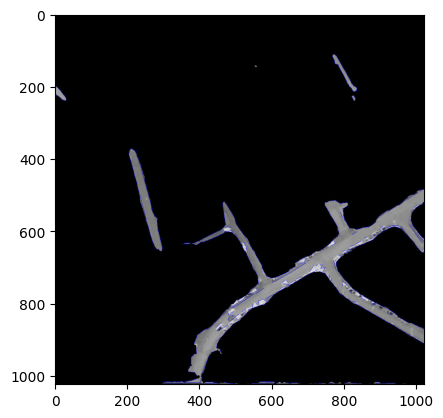

In [12]:
#Create default parametrization LSD
lsd = cv2.createLineSegmentDetector(0)

#Detect lines in the image
lines = lsd.detect(img)[0] #Position 0 of the returned tuple are the detected lines

#Draw detected lines in the image
drawn_img = lsd.drawSegments(img,lines)

#Show image
plt.imshow(drawn_img)

## Grouping LSD pixels into groups (Group = Specific road)

In [23]:
lines = lines.squeeze(1)
print(lines.shape)

(222, 4)


In [29]:
df = pd.DataFrame(lines, columns=list('ABCD'))
plt.rcParams['image.cmap'] = 'Paired'


A = df['A'] #X start
B = df['B'] #Y start
C = df['C'] #X arrive
D = df['D'] #Y arrive
clusterer = hdbscan.HDBSCAN()


df['LENGTH'] = robust_scale(np.sqrt(np.square(df.C-df.A) + np.square(df.D-df.B)))
df['DIRECTION'] = np.arctan2(df.D-df.B, df.C-df.A)
df['COS'] = np.cos(df['DIRECTION'])
df['SIN'] = np.sin(df['DIRECTION'])


columns = ['LENGTH', 'COS', 'SIN']

clusterer = hdbscan.HDBSCAN()
values = df[columns].values
clusterer.fit_predict(values)

cluster_labels = clusterer.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.DataFrame(
        [(values[cluster_labels==n], len(values[cluster_labels==n])) for n in range(num_clusters)],
        columns=["points", "weight"])

df.head()

,A,B,C,D,LENGTH,DIRECTION,COS,SIN
0,534.096130,818.273010,577.802185,802.244690,1.941220,-0.351501,0.938857,-0.344307
1,583.124329,786.873779,728.260559,706.362610,9.183272,-0.506466,0.874464,-0.485090
2,936.874756,586.875671,961.653076,595.047913,0.700371,0.318580,0.949681,0.313218
3,731.365479,712.023560,748.123718,718.128418,0.199718,0.349348,0.939596,0.342285
4,498.194061,605.528992,559.983154,723.461304,7.192157,1.088183,0.464096,0.885785


In [30]:
clusters.head()

,points,weight
0,"[[1.9412197, 0.9388571, -0.34430704], [2.34198...",5
1,"[[0.7003713, 0.94968116, 0.3132183], [0.199717...",184
2,[],0


In [33]:
def get_cmap(n, name='hsv'):
    '''
    Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.
    
    Credits to @Ali
    https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib#answer-25628397
    '''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(num_clusters+1)
colors = {x:cmap(x) for x in range(num_clusters)}
df['CLUSTER'] = np.nan


for x, (cluster, weight) in enumerate(clusters[clusters.weight>0].values.tolist()):
    df_this_cluster = pd.DataFrame(cluster, columns=columns)
    df_this_cluster['TEMP'] = x
    df = df.merge(df_this_cluster, on=columns, how='left')
    df.reset_index(drop=True, inplace=True)
    
    ix = df[df.TEMP.notnull()].index
    df.loc[ix, "CLUSTER"] = df.loc[ix, "TEMP"]
    df.drop("TEMP", axis=1, inplace=True)
    
df['CLUSTER'] = df['CLUSTER'].fillna(num_clusters-1)
df['COLOR'] = df['CLUSTER'].map(colors)
print("Number of clusters : ", num_clusters-1)

df.head()

Number of clusters :  2


,A,B,C,D,LENGTH,DIRECTION,COS,SIN,CLUSTER,COLOR
0,534.096130,818.273010,577.802185,802.244690,1.941220,-0.351501,0.938857,-0.344307,0.0,"(1.0, 0.0, 0.0, 1.0)"
1,583.124329,786.873779,728.260559,706.362610,9.183272,-0.506466,0.874464,-0.485090,2.0,"(0.0, 0.062501968751969, 1.0, 1.0)"
2,936.874756,586.875671,961.653076,595.047913,0.700371,0.318580,0.949681,0.313218,1.0,"(0.031249343749343732, 1.0, 1.3125013125390552..."
3,731.365479,712.023560,748.123718,718.128418,0.199718,0.349348,0.939596,0.342285,1.0,"(0.031249343749343732, 1.0, 1.3125013125390552..."
4,498.194061,605.528992,559.983154,723.461304,7.192157,1.088183,0.464096,0.885785,2.0,"(0.0, 0.062501968751969, 1.0, 1.0)"


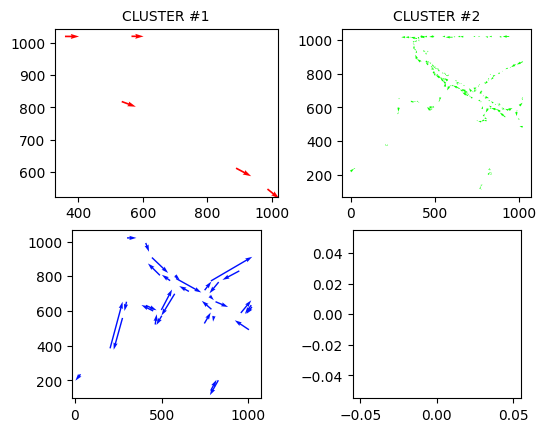

In [39]:
nrows = num_clusters//2 if num_clusters%2==0 else num_clusters//2 + 1
fig,axes = plt.subplots(nrows=nrows, ncols=2)
axes = [y for row in axes for y in row]
for k,ax in enumerate(axes):

    ax.set_aspect('equal', adjustable='box')
    if k+1 <num_clusters:
        ax.set_title(f"CLUSTER #{k+1}", fontsize=10)
    this_df = df[df.CLUSTER==k]
    #print("this_df.A: {}".format(this_df.A))
    #print("this_df.B: {}".format(this_df.B))
    ax.quiver(
        this_df.A, #X
        this_df.B, #Y
        (this_df.C-this_df.A), #X component of vector
        (this_df.D-this_df.B), #Y component of vector
        angles = 'xy', 
        scale_units = 'xy', 
        scale = 1, 
        color=this_df.COLOR
        )